# Cancer Detection Using Artificial Intelligence                                                                                         

Andre Hochmuth
***

## Introduction

Skin cancers are the most common type of cancers. In fact, more people are diagnosed with skin cancer each year in the U.S. than all other cancers combined (Skin Cancer Foundation). Fortunately, "the estimated five-year survival rate for patients whose melanoma is detected early is about 99% in the U.S." If the cancer reaches the lymph nodes the survival rate falls to 63% and 20% when the disease metastasizes to distant organs. As you can see from these numbers, if skin cancer is found and treated early, their is a high chance of effective treatment. However, if left untreated, skin cancers can metastasize and become deadly.

The diagnosis of skin cancer begins with a clinical screening, and then follows with dermascopic analysis, biopsy, and histopathological examination. If we can replace the initial clinical screening with an automated classification of skin lesions using images, we can provide access to clinical screening for people all around the world as long as they can access a smartphone with a camera.

#### Applications
- Effective tool for dermatologists in aiding diagnosis
- Aid in education of skin cancer diagnosis to doctors learning how to properly diagnose skin cancers
- Provide universal access of skin cancer diagnostic care



#### Challenges
- Fine grained variability in the appearance of skin lesions
- Variability in photos: zoom, angle, lighting, aspect ratio, focus, exposure, etc.
***

## Abstract

I will be implementing an end-to-end <b>Convolutional Neural Network (CNN) </b> that classifies a given image of a skin lesion into <b>7 categories</b>. <br>
The CNN will be trained using the <b>HAM10000 Image Dataset</b>. <br> 
<b>Goal:</b> <br>
The main goal of this project is to develop a tool that can be used by doctors or in circumstances that prevent a proper clinical screening, in which high priority patients can be chosen quickly using this tool. The images will be pre-processed and analyzed locally through the tool to ensure the patient's medical information is kept safe. Due to the nature of the tool being used only as a screening tool, it is safe to say that the accuracy of the tool is not relevant, and we only need to make sure that no false-negatives occur.
***

## Methods

We will use the [HAM10000 (Human Against Machine) Image Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T). The dataset is made up of 10015 dermatoscopic images and the type of skin cancer associated with it. It was made for machine learning academic purposes. We can create a standardized dataset using this (just like the well known MNIST Digits dataset).

#### Classifications:
<b>1. Melanocytic nevi </b>
    - A form of benign skin lesion.
<b>2. Melanoma </b>
    - Deadliest type of skin cancer.
<b>3. Benign keratosis-like lesions </b> <br>
<b>4. Basal cell carcinoma (BCC) </b>
    - Most common type of skin cancer
<b>5. Actinic keratoses (AK) </b>
    - These dry, scaly patches or spots are precancerous growths.
<b>6. Vascular lesions </b>
    - Present from birth, usually benign.
<b>7. Dermatofibroma </b>
    - Common benign fibrous nodule that most often arises on the skin of the lower legs

<i>(Definitions taken from American Academy of Dermatology) </i>

#### Software Framework:
- [Tensorflow](https://www.tensorflow.org/):
    - We will be using Tensorflow as our back-end to enable us to perform heavy numerical computations
    - Tensorflow.js has a Javascript Library for in-browser capability. This is extremely helpful to meet the requirements of our goal, in which we can use Tensorflow.js to run existing models in the browser.
- [Keras](https://keras.io/):
    - We will be using the Keras API to allow quick development and testing of CNN's. 
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/api.html):
    - Pandas provides us with high performance data structures and data analysis tools. 
- [Scikit-Learn](https://pypi.org/project/scikit-learn/):
    - We will mainly use Scikit to produce a confusion matrix and to create our training and testing datasets. Although Scikit can be used for many other purposes in machine learning. 
***

<div style="background-color:rgba(200, 200, 0, .5); text-align:center; vertical-align: middle; padding:40px 0;">
<b>Data PreProcessing</b>
 
 </div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(1322)
import itertools
from keras.applications.vgg16 import VGG16
from keras.layers.normalization import BatchNormalization
import keras
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

/Users/andrehochmuth/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [3]:
skin_dir = os.path.join('/Users/andrehochmuth/documents/cs440/Project/','input')

#combine pictures into one directory
path_dir = {os.path.splitext(os.path.basename(x))[0]: x
           for x in glob(os.path.join(skin_dir,'*','*.jpg'))}

type_dict = {
      'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
#read in the csv metadata
meta_df = pd.read_csv('/Users/andrehochmuth/documents/cs440/Project/input/HAM10000_metadata.csv')
# Create some new columns (path to image, human-readable name) and review them
meta_df['path'] = meta_df['image_id'].map(path_dir.get)
meta_df['cell_type'] = meta_df['dx'].map(type_dict.get)
meta_df['cell_type_idx'] = pd.Categorical(meta_df['cell_type']).codes
meta_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
7100,HAM_0006159,ISIC_0028977,bkl,consensus,50.0,female,upper extremity,/Users/andrehochmuth/documents/cs440/Project/i...,Benign keratosis-like lesions,2
5372,HAM_0001812,ISIC_0024326,nv,follow_up,75.0,male,back,/Users/andrehochmuth/documents/cs440/Project/i...,Melanocytic nevi,4
2242,HAM_0004898,ISIC_0024932,mel,histo,55.0,female,lower extremity,/Users/andrehochmuth/documents/cs440/Project/i...,Melanoma,5


We want to cleanup the data to get rid of any null values. In this case all of the null values are located in the age category, so we can just fill them in with the mean age. 

In [5]:
meta_df['age'].fillna((meta_df['age'].mean()), inplace=True)

### Data Analysis

#### Technical Validation Distribution
The technical validation field has 4 categories. The definitions of each below were taken from the dataset source.
1. <b>Histopathology(Histo)</b>: Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists.
2. <b>Confocal</b>: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.
3. <b>Follow-up</b>: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
4. <b>Consensus</b>: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

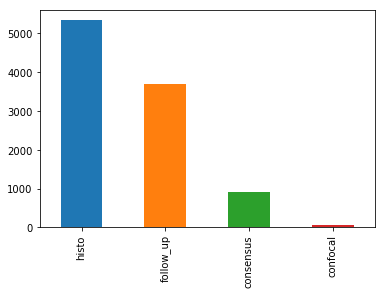

In [6]:
meta_df['dx_type'].value_counts().plot(kind='bar')

We can see from this distribution that most skin cancers have been diagnosed upon thorough histopathologic examination. This helps verify that our dataset is reliable.

#### Class Distribution

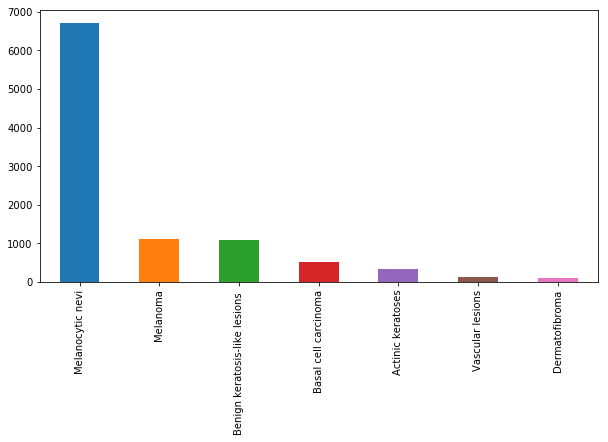

In [7]:
#distibution of different cell types
fig,ax1 = plt.subplots(1,1,figsize=(10,5))
meta_df['cell_type'].value_counts().plot(kind='bar',ax=ax1)

As you can see above, our dataset is very skewed towards Melanocytic Nevi. In order to prevent our model from being biased, we need to balance our data by getting rid of some of the Melanocytic Nevi images. 

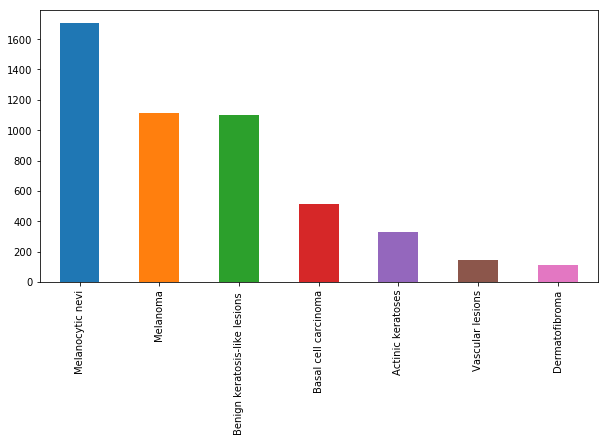

In [8]:
meta_df = meta_df.drop(meta_df[meta_df.cell_type_idx == 4].iloc[:5000].index)
fig,ax1 = plt.subplots(1,1,figsize=(10,5))
meta_df['cell_type'].value_counts().plot(kind='bar',ax=ax1)

#### Localization Distribution (Location of Lesion)

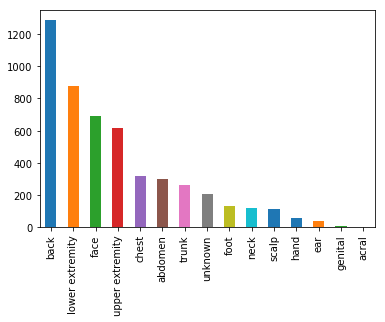

In [9]:
#distribution of localization of the images
meta_df['localization'].value_counts().plot(kind='bar')

We can see that a majority of the images are taken from the back, with the genitals, hand, and ears having the lowest amount of images.

#### Male to Female Distribution

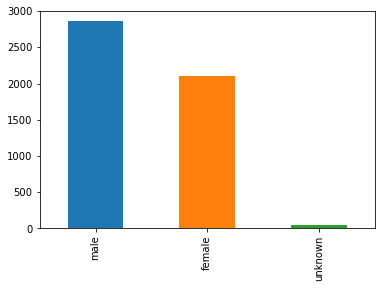

In [10]:
#distribution of the sexes
meta_df['sex'].value_counts().plot(kind='bar')

We can see that their are over 500 more males than female images included in the dataset. The values are close enough to not cause any real issues. 

#### Age Distribution

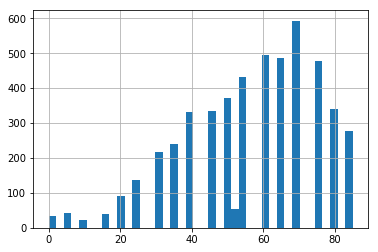

In [11]:
meta_df['age'].hist(bins=40)

Our data is taken mostly from age 50-80. This is interesting to note, since we would expect that the older age groups would have more data and be more commonly diagnosed with skin cancer, but instead we have most data coming from the mid range. 

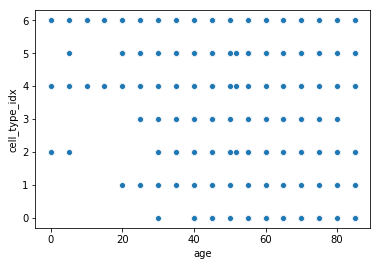

In [12]:
sns.scatterplot('age','cell_type_idx',data=meta_df)

It looks like a few types of skin lesions are only prevalent in ages above 20 years.

#### Resize Images
We should resize the images to make sure that we have a standardized set.

In [13]:
meta_df['image'] = meta_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

Here we can plot a sample of a few images from each category out of the seven different classes to compare.

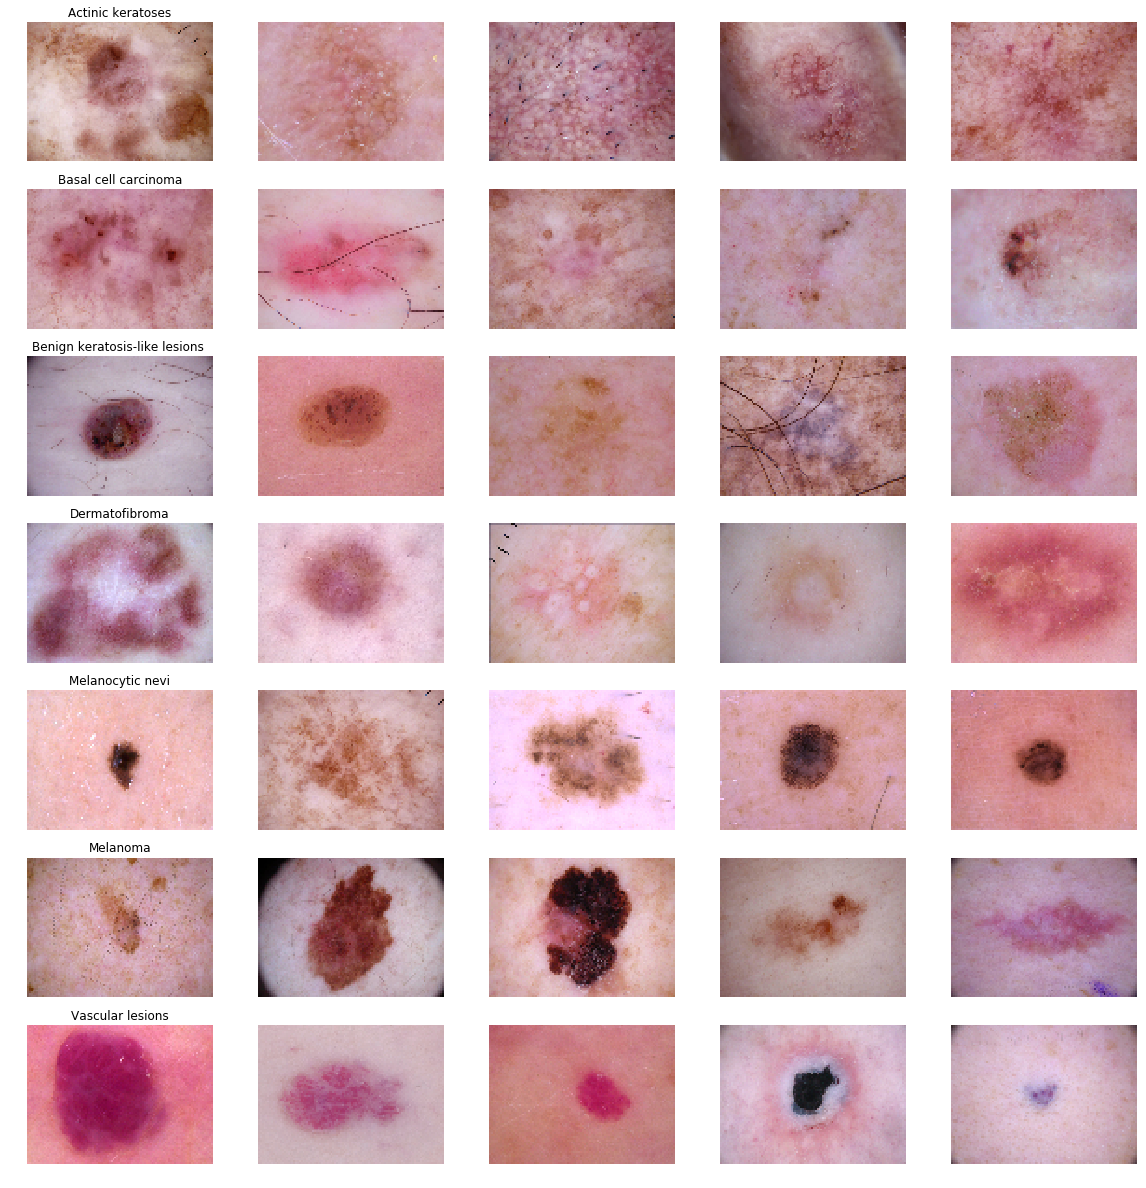

In [14]:
n = 5
fig,m_axs = plt.subplots(7,n,figsize=(4*n,3*7))
for n_axs, (type_name,type_rows) in zip(m_axs,meta_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax,(_,c_row) in zip(n_axs,type_rows.sample(n,random_state=9).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png',dpi=300)

#### Analyze Color Channels

In order to analyze the RGB values, we can get the mean value across each color channel for all the images of each classification type, and then plot them using various different graph types from the Seaborn Library.

In [15]:
rgb_info_df = meta_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(5)

,Blue_mean,Green_mean,Red_mean,Gray_mean
9461,0.977224,0.868592,1.154184,138.399067
189,0.939569,0.946902,1.113529,161.963689
9284,1.028236,0.887229,1.084535,149.975067
8383,0.896976,0.861170,1.241853,149.996222
1635,0.905113,0.889036,1.205851,125.627333


/Users/andrehochmuth/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


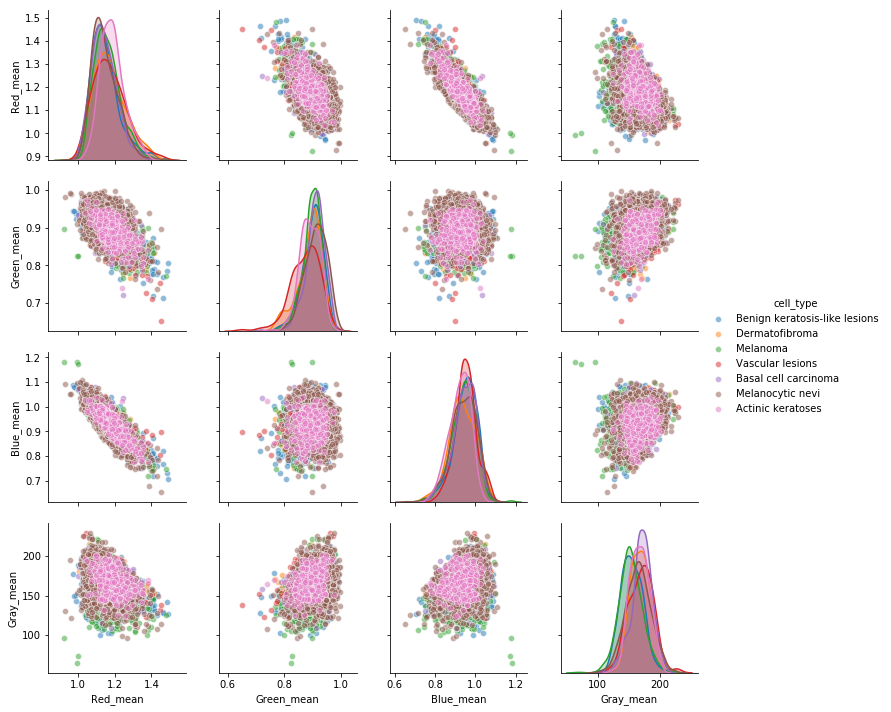

In [16]:
for c_col in rgb_info_df.columns:
    meta_df[c_col] = rgb_info_df[c_col].values

sns.pairplot(meta_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']], 
             hue='cell_type', plot_kws = {'alpha': 0.5})

/Users/andrehochmuth/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


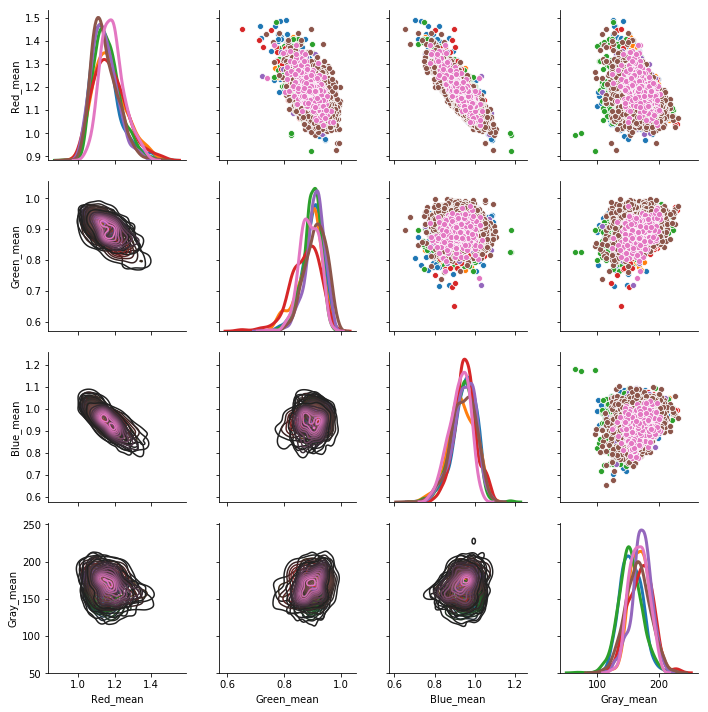

In [17]:
g = sns.PairGrid(meta_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']],hue='cell_type', diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

In [18]:
features=meta_df.drop(columns=['cell_type_idx'],axis=1)
target=meta_df['cell_type_idx']

<div style="background-color:rgba(0, 200, 0, .5); text-align:center; vertical-align: middle; padding:40px 0;">
<b>The Neural Net</b>
 
 </div>

<b>Create Training and Test Datasets</b>

In [19]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

#### Normalize Datasets

In [20]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

#### Label Classes
Labels are the 7 different classes of skin cancer types from 0 to 6.

In [21]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#### Training and Validation Split
90% Training Set : 10% Validation Set

In [22]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [23]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

<b>Define the deep convolutional network architecture.</b>

In [24]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
__________

***
### Training the Deep Convolutional Neural Network:

In [25]:
#batch_size = 32 # Todo: experiment with this variable more
#epochs = 12

#history = model.fit(x_train, y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(x_test, y_test))

#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

***
## Results

Our results were not as accurate as we want them to be. 52% accuracy is definitely not ideal. Luckily, there are many techniques that we still haven't tried with our neural net model that can be used. We will try a couple until our testing accuracy improves to a safe point. We also need to train our model for longer. The only problem with doing so is that computation becomes extremeley expensive/time consuming. 

### Improving the Model

#### Data Augmentation
We can see that we only end up with a 52% accuracy so far. This is not ideal, so we ask ourself what methods are their that we can use to improve the model? <br>
The first thing that comes to mind is to avoid overfitting. One way to fix this is to expand our dataset artificially or better yet to get a bigger dataset. Since we will not be using a bigger dataset in this project, we will stick to artificially expanding our dataset. 
<br><b>Goal:</b> <br>
Expand the current dataset using small transformations of the current variations to avoid overfitting.  <br> <br>
This technique is called data augmentation (Raj). In convolutional neural networks, common data augmentation techniques are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, etc. We can use these techniques to create a much larger dataset of training examples. Some forms of data augmentation even use trained neural networks to create new images based off of the old images. We won't be using this technique as it is computationally expensive.

In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

##### Data Augmentation Techniques Used
- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height 

#### Optimization Algorithm
Another technique we can use to improve our model is to set an optimization algorithm. <br>
We will be using the <b>Adaptive Moment Estimation (Adam) Algorithm </b> which can adaptively compute learning rates for each parameter (Ruder). Adam combines characteristics from Adadelta and RMSprop as well as storing an exponentially decaying average of past gradients which acts like momentum. Adam is pretty much a standard for many deep learning models. We can sum up the reasons for choosing Adam in two main points: 
       1. Uses momentum for faster convergence
       2. Separate learning rate for each parameter is adaptively chosen
Of course if we had high computational power we could choose a different optimization algorithm, but we will stick to Adam for its fast convergence rate.

In [27]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [28]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [29]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Now let run the program again to see how our two techniques have improved our model.
***

In [30]:
# Fit the model
epochs = 55
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/55
361/361 [==============================] - 91s 253ms/step - loss: 1.5622 - acc: 0.3593 - val_loss: 1.4503 - val_acc: 0.4204
Epoch 2/55
361/361 [==============================] - 97s 268ms/step - loss: 1.4466 - acc: 0.4025 - val_loss: 1.4187 - val_acc: 0.4030
Epoch 3/55
361/361 [==============================] - 98s 270ms/step - loss: 1.4302 - acc: 0.4116 - val_loss: 1.3481 - val_acc: 0.4552
Epoch 4/55
361/361 [==============================] - 96s 265ms/step - loss: 1.3966 - acc: 0.4205 - val_loss: 1.3162 - val_acc: 0.4328
Epoch 5/55
361/361 [==============================] - 99s 274ms/step - loss: 1.3682 - acc: 0.4357 - val_loss: 1.3137 - val_acc: 0.4801
Epoch 6/55
361/361 [==============================] - 97s 268ms/step - loss: 1.3478 - acc: 0.4535 - val_loss: 1.3411 - val_acc: 0.4353
Epoch 7/55
361/361 [==============================] - 96s 267ms/step - loss: 1.3128 - acc: 0.4648 - val_loss: 1.2244 - val_acc: 0.4975
Epoch 8/55
361/361 [==============================] - 9

### Validating the Model:

In [31]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

402/402 [==============================] - 4s 9ms/step
Validation: accuracy = 0.559701  ;  loss_v = 1.088514
Test: accuracy = 0.582253  ;  loss = 1.158676


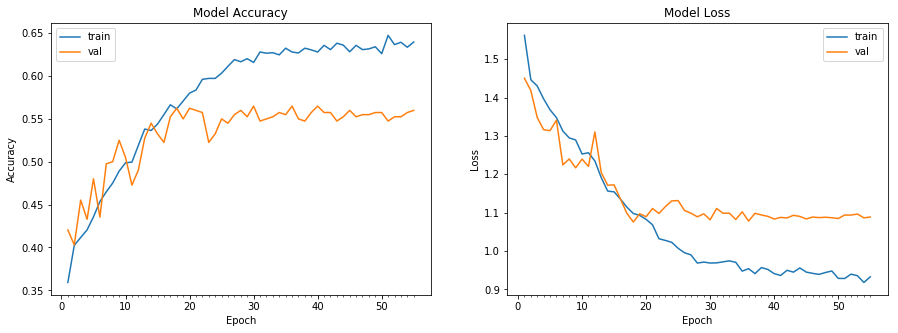

In [32]:
plot_model_history(history)

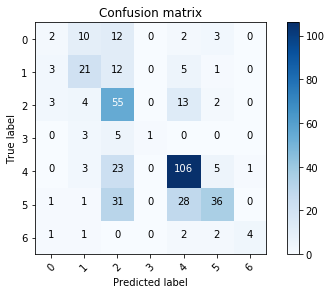

In [33]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

We can also plot the incorrectly predictions to see which category was the hardest to predict.

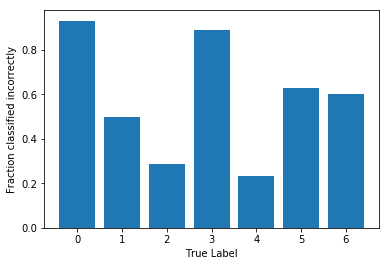

In [34]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

Melanocytic Nevi and Basal Cell Carcinoma (BCC) were the most innacurately classified types of skin lesions. Unfortunately, a high rate of each was incorrectly classified. This leaves a lot of room for improvement in the model. 

***
## Conclusions

Our model was not nearly accurate enough for use in the field. Though we were able to show that through a few techniques we could improve our model by a large amount. We would also want access to some more specialized hardware in order to train huge models so we can try different models on. Others have reached accuracies of over 75% with the same model and structures so I cannot seem to pinpoint the reason for my low accuracy other than just not training it long enough. When I view other examples online the only difference is that mine trained 321/321 at a time while theirs trained 721/721 at a time. This difference is key in the amount of training done.

#### Challenges: 
- It was especially difficult for me to get all packages and dependencies to work correctly. I had to install and update many things before I could properly use TensorFlow and Keras together.

- My first model only gave me a about a 52% accuracy, so I had to find ways to improve the existing model to reach a good threshold accuracy. 

- My model was extremely slow to train using my personal computer. I had to lower the amount of training iterations multiple times which resulted in having a much lower accuracy rate than I was aiming for. In the future I will have to look into Cloud Computing or using an external GPU with my Mac OS. 

- I was only able to reach about a 60% accuracy, while models online using the same framework and model structures had accuracies of up to 77%. 
        -This goes to show how important every detail of training neural networks is. From data cleanup to optimization.
        -Even hardware can be important to be able to train neural networks thororoughly as I was never able to completely reach a good training threshold due to the immense training time.

#### What I Learned:
- I learned how to properly set up directories and use TensorFlow and Keras within Jupyter Notebooks
- I learned techniques to improve model accuracy
    - Data Augmentation Techniques
    - Optimization/Annealer Algorithms
- I learned some techniques to data wrangling and data analysis

#### Applications/Future Work:
- Move the model to a mobilenet using Tensorflowjs mobile libraries
- Improve model accuracy to above 75% using more neural network modeling techniques
- Use more advanced hardware to experiment with huge models and training times to find more accurate methods
- Weight melanoma and other malignant forms of skin cancer so that chances of false negatives are extremeley low.

***
## Bibliography

#### Dataset

- Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 (2018). doi: 10.1038/sdata.2018.161

#### References

- “Skin Cancer Foundation.” Squamous Cell Carcinoma (SCC) - SkinCancer.org, 3 May 2018, www.skincancer.org/skin-cancer-information/skin-cancer-facts.

- “Types of Skin Cancer.” Employment and Benefits | American Academy of Dermatology, www.aad.org/public/spot-skin-cancer/learn-about-skin-cancer/types-of-skin-cancer.

- Ruder, Sebastion. “An Overview of Gradient Descent Optimization Algorithms.” An Overview of Gradient Descent Optimization Algorithms, 29 Nov. 2018, ruder.io/optimizing-gradient-descent/index.html#adam.

- Raj, Bharath. “Data Augmentation | How to Use Deep Learning When You Have Limited Data - Part 2.” Medium.com, Medium, 11 Apr. 2018, medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced.

<b>Code Used From: </b> <br>
- Step by Step: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

- Basic Neural Network Training: https://www.kaggle.com/twhitehurst3/skin-cancer-mnist-classification/notebook

- Loading and Processing: https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing

- Creating Web App: https://www.kaggle.com/vbookshelf/skin-lesion-analyzer-tensorflow-js-web-app/notebook

Please note that a large amount of code in this project was outsourced. My main goal was in learning how to use Tensorflow and Keras while learning data cleanup techniques as well as common neural network modeling practices. This project serves as more of a "hands-on research project" than an actual implementation.

In [1]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('Hochmuth-Project.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

/Users/andrehochmuth/anaconda/lib/python3.5/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/Users/andrehochmuth/anaconda/lib/python3.5/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Word count for file Hochmuth-Project.ipynb is 2298
